In [1]:
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import f1_score

# Untuk melakukan ekstraksi data pada suatu kolom
import re 

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split

import time
import warnings
warnings.filterwarnings('ignore')

# Set rows ke 100 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 100)

In [2]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler

In [3]:
X = pd.read_csv("train_features.csv")
y = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_features.csv")
test = test.drop(['ID'], axis=1)
submission_format = pd.read_csv("submission_format.csv")

In [4]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    # summ['top value'] = desc['top'].values
    # summ['Freq'] = desc['freq'].values

    return summ

In [5]:
summary(X).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [6]:
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


In [7]:
train = pd.concat([X, y], axis=1)

In [8]:
train.sample(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
3048,1966,Doktor,Sendiri,74372000.0,1.0,1.0,58.0,6069.0,14161.0,0.0,10115.0,0.0,1.0,1.0,0.0,2013-05-12,0
3611,1971,Doktor,Cerai,49845000.0,1.0,0.0,18.0,2023.0,50575.0,30345.0,NaN,2.0,4.0,3.0,0.0,2012-09-19,5
1367,1963,Doktor,Sendiri,165099000.0,0.0,0.0,0.0,28322.0,708050.0,76874.0,42483.0,1.0,4.0,NaN,0.0,2013-05-10,0
602,1951,Magister,Menikah,135011336.0,0.0,1.0,55.0,10575.0,97798.0,12598.0,6709.0,4.0,4.0,7.0,0.0,NaN,4
3297,1975,Sarjana,Menikah,72883000.0,0.0,1.0,11.0,0.0,24276.0,6069.0,2023.0,0.0,0.0,3.0,0.0,2012-10-15,0
3117,1970,Magister,Rencana Menikah,54913060.0,0.0,0.0,90.0,26835.0,209828.0,47065.0,33175.0,0.0,0.0,9.0,0.0,NaN,0
1717,1959,Sarjana,Menikah,137989421.0,0.0,1.0,68.0,50515.0,354421.0,33220.0,65013.0,3.0,5.0,9.0,0.0,NaN,4
2593,1983,Magister,Sendiri,76377879.0,1.0,0.0,23.0,3825.0,223290.0,32513.0,0.0,3.0,7.0,5.0,0.0,NaN,5
1826,1959,Magister,Sendiri,126885000.0,1.0,NaN,42.0,16184.0,95081.0,6069.0,20230.0,7.0,10.0,5.0,0.0,2013-03-11,0
1739,1959,Magister,Rencana Menikah,151007472.0,1.0,1.0,45.0,155688.0,528000.0,73647.0,48552.0,2.0,6.0,11.0,0.0,NaN,0


Text(0, 0.5, 'Percentage')

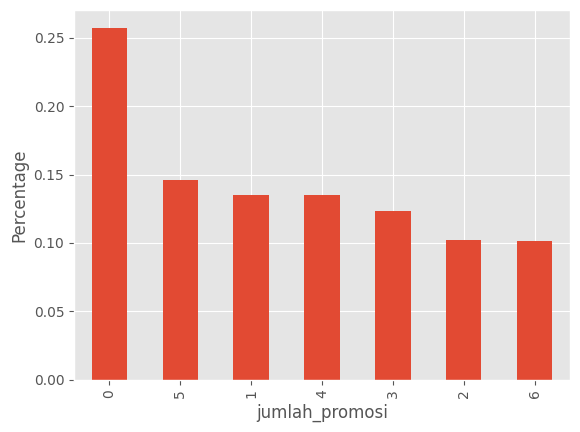

In [9]:
train['jumlah_promosi'].value_counts(normalize = True).plot(kind = 'bar')
plt.ylabel('Percentage')

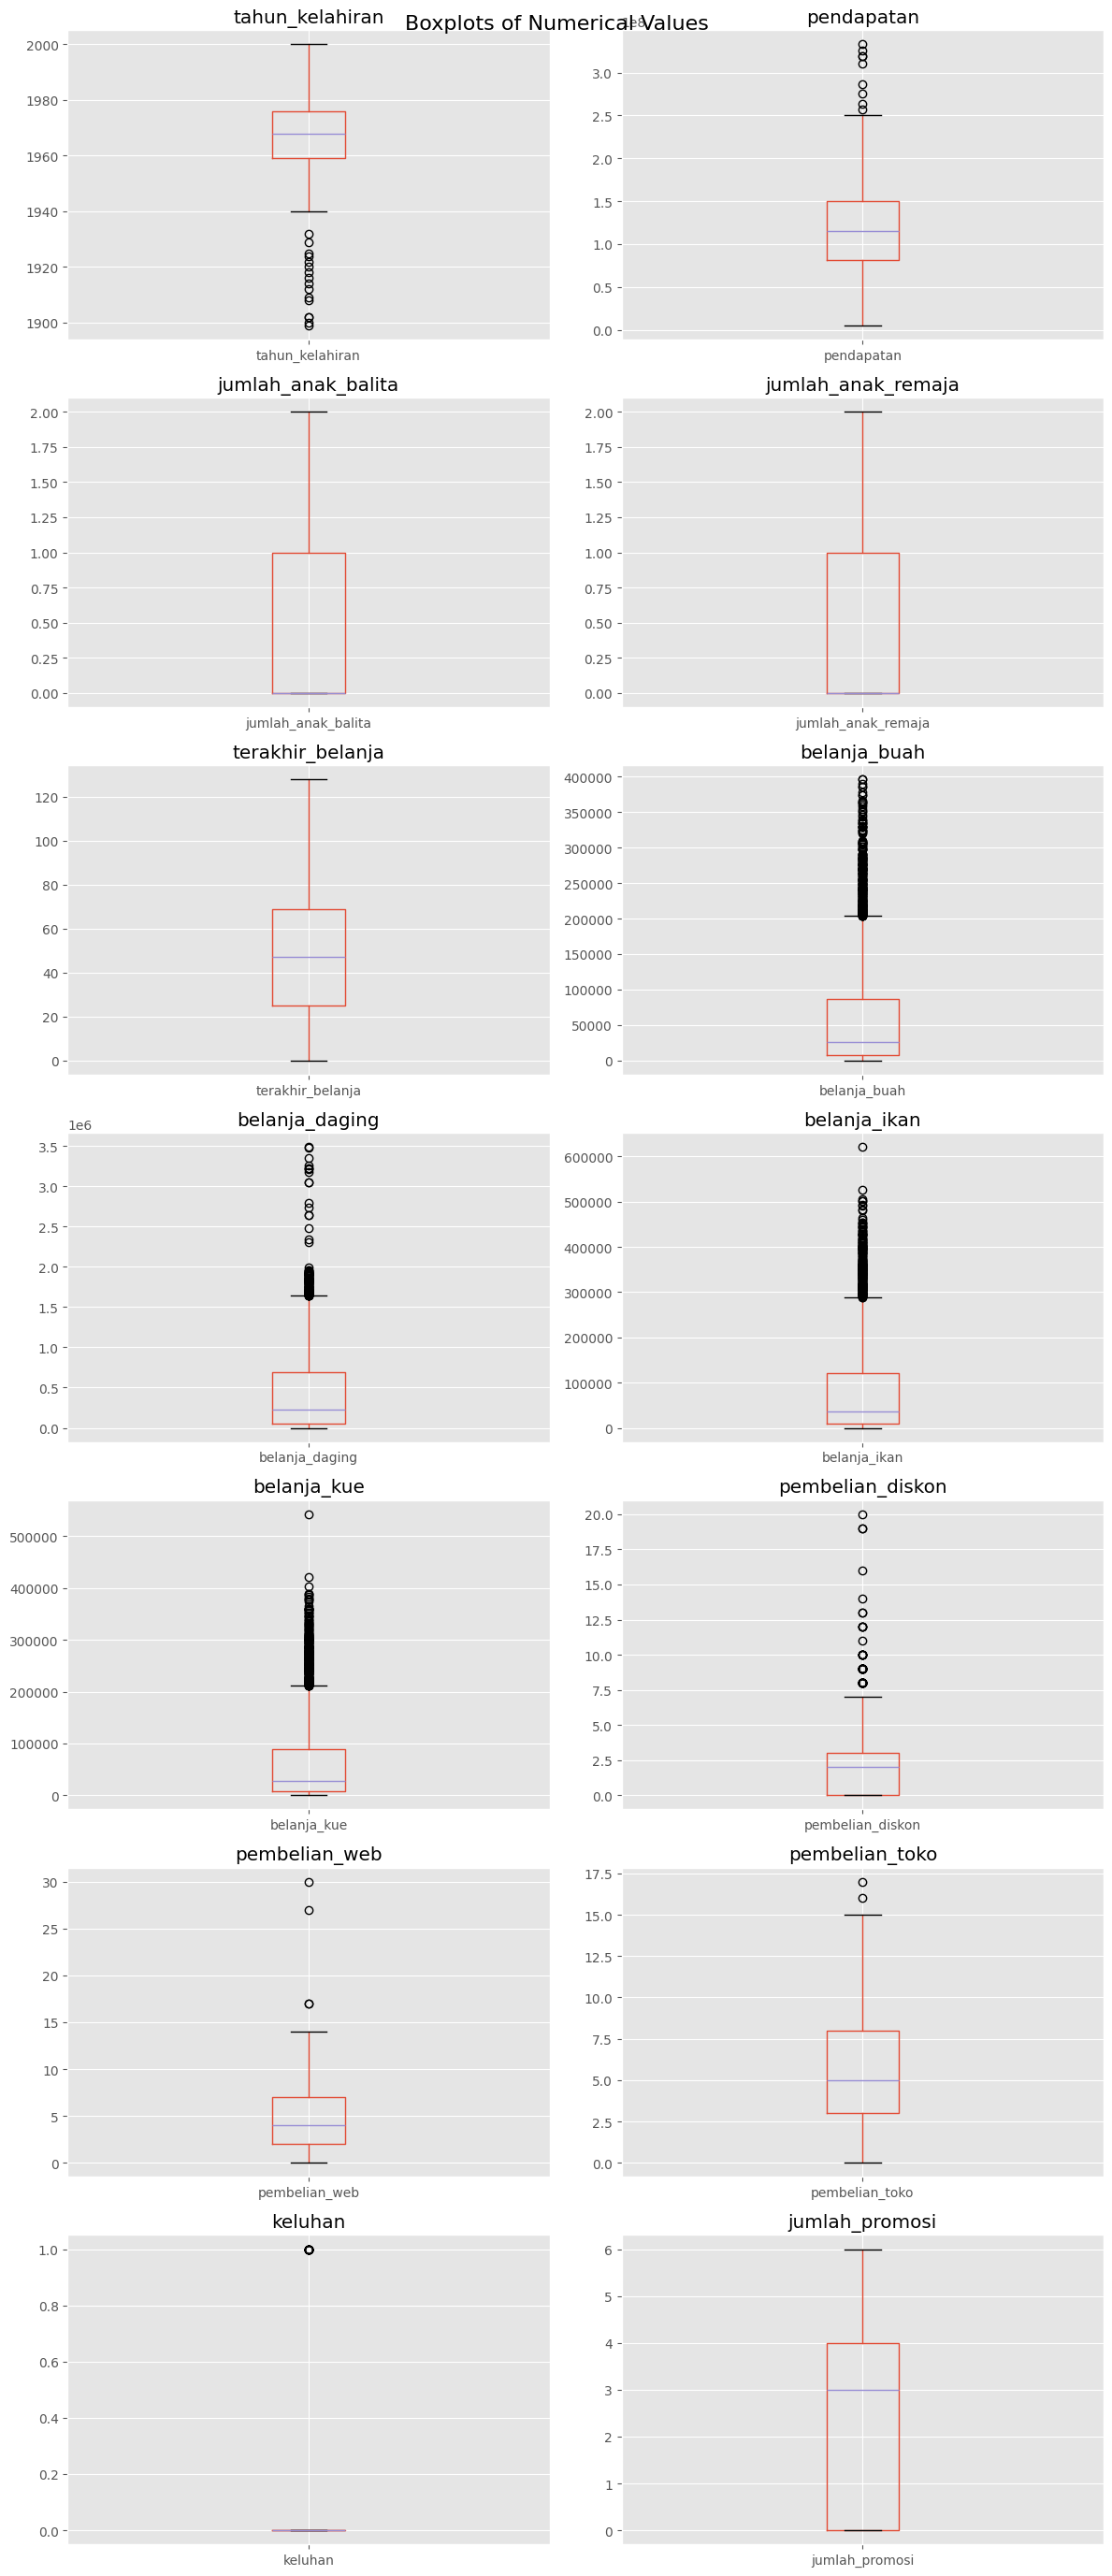

In [10]:
numerical_data = train.select_dtypes(include=[np.number])  # Select numerical columns

num_cols = numerical_data.shape[1]
num_rows = int(np.ceil(num_cols / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
fig.suptitle('Boxplots of Numerical Values', fontsize=16)

for i, column in enumerate(numerical_data.columns):
    ax = axes[i // 2, i % 2] if num_rows > 1 else axes[i % 2]
    numerical_data.boxplot(column=column, ax=ax)
    ax.set_title(column)
    

plt.tight_layout()
plt.show()

In [11]:
def preprocessing(df):
    df = df.drop(['jumlah_anak_remaja','jumlah_anak_balita','pendidikan','tahun_kelahiran','terakhir_belanja'
                        ,'status_pernikahan', 'tanggal_menjadi_anggota','keluhan'], axis=1)
    
    
    # Hapus nilai aneh pada pendidikan dan status_pernikahan
    # df = df[df["pendidikan"].str.contains("5") == False]
    # df = df[df["status_pernikahan"].str.contains("5") == False]
    
    # Pemeblian diatas 15 diubah jadi 15
    # train.loc[train['pembelian_web'] > 15, 'pembelian_web'] = 15
    # train.loc[train['pembelian_toko'] > 15, 'pembelian_toko'] = 15
    
    # Fill Null Val dengan interpolate
    # train['pendapatan'] = train['pendapatan'].interpolate(method ='pad', limit_direction ='forward')
    # train['terakhir_belanja'] = train['terakhir_belanja'].interpolate(method ='pad', limit_direction ='forward')
    # train['belanja_buah'] = train['belanja_buah'].interpolate(method ='pad', limit_direction ='forward')
    # train['belanja_daging'] = train['belanja_daging'].interpolate(method ='pad', limit_direction ='forward')
    # train['belanja_ikan'] = train['belanja_ikan'].interpolate(method ='pad', limit_direction ='forward')
    # train['belanja_kue'] = train['belanja_kue'].interpolate(method ='pad', limit_direction ='forward')
    
    # Fill Null Val dengan median
    df = df.fillna(df.median())

    # Change data type to int64
    numerical_data = df.select_dtypes(include=[np.number])  # Select numerical columns
    for i, column in enumerate(numerical_data.columns):
        df[column] = df[column].astype('int64')

    return df

In [12]:
# Preprocess train set
train = preprocessing(train)
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
pendapatan,int64,0,0,3622,5073000.000000,332884000.000000,114539827.816348,42365378.562972
belanja_buah,int64,0,0,2536,0.000000,396508.000000,58222.884988,72594.990959
belanja_daging,int64,0,0,2951,0.000000,3489675.000000,428474.859314,502039.680752
belanja_ikan,int64,0,0,2628,0.000000,621600.000000,79134.689547,97921.333038
belanja_kue,int64,0,0,2475,0.000000,542164.000000,61383.012313,77608.980718
pembelian_diskon,int64,0,0,18,0.000000,20.000000,2.119728,2.050738
pembelian_web,int64,0,0,18,0.000000,30.000000,4.417605,2.938233
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.733822,3.142808
jumlah_promosi,int64,0,0,7,0.000000,6.000000,2.585800,2.101845


In [13]:
# Preprocess test set
test = preprocessing(test)
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
pendapatan,int64,0,0,3610,2998899.000000,1305740000.000000,116399722.873232,49676148.242755
belanja_buah,int64,0,0,2574,0.000000,408646.000000,59689.324515,75067.863160
belanja_daging,int64,0,0,2943,0.000000,3271191.000000,441607.259036,501409.832401
belanja_ikan,int64,0,0,2661,0.000000,574932.000000,83012.402567,101583.197772
belanja_kue,int64,0,0,2526,0.000000,532049.000000,62109.273180,76845.998096
pembelian_diskon,int64,0,0,17,0.000000,17.000000,2.096909,2.065482
pembelian_web,int64,0,0,16,0.000000,27.000000,4.443164,2.867256
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.794919,3.212271


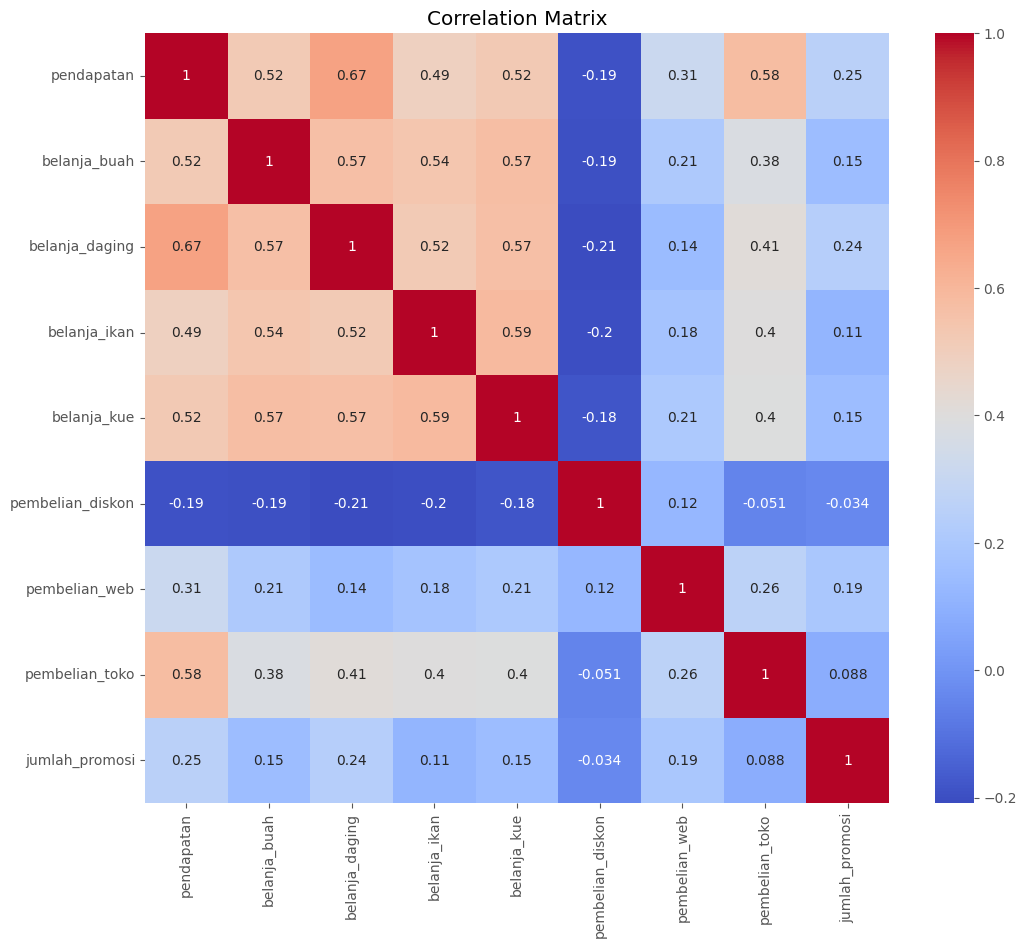

In [14]:
# Menghitung matriks korelasi
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [15]:
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

### Modelling Part 1

In [16]:
skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 42)

In [17]:
# Define the objective function for optimization
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'random_state': 42,
        'n_jobs' : -1
    }

    model = XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)

    return np.mean(f1_scores)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train a model with the best hyperparameters
best_model = XGBClassifier(**best_params)
XGB_cv = cross_val_score(best_model, X, y, scoring='f1_macro', cv=skf, n_jobs=-1)

# Print the average 10-folds oof Macro F-Score of the XGBoost model
print(f"The average 10-folds oof Macro F-Score of the XGBoost model is {XGB_cv.mean()}")

[I 2024-04-21 09:37:33,470] A new study created in memory with name: no-name-b5dc5796-74b0-4f37-87ed-c4e331b0947c
[I 2024-04-21 09:37:52,792] Trial 0 finished with value: 0.6580175511771726 and parameters: {'max_depth': 4, 'learning_rate': 0.059624535504588065, 'n_estimators': 875, 'gamma': 0.08655395891897717, 'min_child_weight': 3, 'colsample_bytree': 0.54497202693496, 'subsample': 0.7977482362987514}. Best is trial 0 with value: 0.6580175511771726.
[I 2024-04-21 09:38:16,564] Trial 1 finished with value: 0.6792543427018682 and parameters: {'max_depth': 5, 'learning_rate': 0.05186371244819027, 'n_estimators': 877, 'gamma': 0.07655279914121119, 'min_child_weight': 4, 'colsample_bytree': 0.9611028526502678, 'subsample': 0.9162548322802542}. Best is trial 1 with value: 0.6792543427018682.
[I 2024-04-21 09:38:44,658] Trial 2 finished with value: 0.6618424258906386 and parameters: {'max_depth': 7, 'learning_rate': 0.023251605520678086, 'n_estimators': 876, 'gamma': 0.5545642017791371, 'mi

Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.09916225830028798, 'n_estimators': 130, 'gamma': 0.038074194941388036, 'min_child_weight': 1, 'colsample_bytree': 0.6651907837729656, 'subsample': 0.9481004214818249}
The average 10-folds oof Macro F-Score of the XGBoost model is 0.7056342852603348


In [18]:
# def objective(trial):
#     # Define the search space for hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['gini']),
#         'max_depth': trial.suggest_int('max_depth', 10, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_int('max_features', 1, 10),
#         'random_state': 1,
#         'n_jobs': -1
#     }

#     # Initialize the RandomForestClassifier with the suggested hyperparameters
#     rf = RandomForestClassifier(**params)

#     # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train the model and make predictions on the test set
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)

#     # Calculate F1 score (macro average) as the metric to optimize
#     f1 = f1_score(y_test, y_pred, average='macro')

#     return f1

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# # Train a model with the best hyperparameters
# best_rf = RandomForestClassifier(**best_params)
# best_rf.fit(X, y)

# #Use the best model for predictions or further analysis

In [19]:
# def objective(trial):
#     # Define the search space for hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['entropy']),
#         'max_depth': trial.suggest_int('max_depth', 10, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_int('max_features', 1, 10),
#         'random_state': 1,
#         'n_jobs': -1
#     }

#     # Initialize the RandomForestClassifier with the suggested hyperparameters
#     rf = RandomForestClassifier(**params)

#     # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train the model and make predictions on the test set
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)

#     # Calculate F1 score (macro average) as the metric to optimize
#     f1 = f1_score(y_test, y_pred, average='macro')

#     return f1

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# # Train a model with the best hyperparameters
# best_rf = RandomForestClassifier(**best_params)
# best_rf.fit(X, y)

# #Use the best model for predictions or further analysis

In [20]:
# def objective(trial):
#     # Define the search space for hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['log_loss']),
#         'max_depth': trial.suggest_int('max_depth', 10, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_int('max_features', 1, 10),
#         'random_state': 1,
#         'n_jobs': -1
#     }

#     # Initialize the RandomForestClassifier with the suggested hyperparameters
#     rf = RandomForestClassifier(**params)

#     # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train the model and make predictions on the test set
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)

#     # Calculate F1 score (macro average) as the metric to optimize
#     f1 = f1_score(y_test, y_pred, average='macro')

#     return f1

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# # Train a model with the best hyperparameters
# best_rf = RandomForestClassifier(**best_params)
# best_rf.fit(X, y)

# #Use the best model for predictions or further analysis

In [21]:
# %%time
# RF_cv = cross_val_score(RandomForestClassifier(**{'n_estimators': 1000,
#                                                   'criterion': 'log_loss',
#                                                   'max_depth': 30,
#                                                   'min_samples_split': 3,
#                                                   'min_samples_leaf': 1,
#                                                   'max_features': 4,
#                                                   'random_state': 1,
#                                                   'n_jobs': -1}),
#                         X, 
#                         y, 
#                         scoring = 'f1_macro',
#                         cv = skf, 
#                         n_jobs = -1)

# print(f"The 10-folds Macro F-Score of the RF is {RF_cv.mean()}")

In [22]:
# %%time
# XGB_cv = cross_val_score(XGBClassifier(**{'max_depth': 10, 
#                                           'learning_rate': 0.016018024956360944, 
#                                           'n_estimators': 918, 
#                                           'gamma': 0.01485307934361231, 
#                                           'min_child_weight': 1, 
#                                           'colsample_bytree': 0.8873994324096951, 
#                                           'subsample': 0.6718047943098943}), 
#                           X,
#                           y,
#                           scoring = 'f1_macro',
#                           cv = skf, 
#                           n_jobs = -1)

# print(f"The average 10-folds oof Macro F-Score of the XGBoost model is {XGB_cv.mean()}") 

In [23]:
# %%time
# XGB_cv = cross_val_score(XGBClassifier(**{'max_depth': 7,
#                                           'learning_rate': 0.03570188608151033,
#                                           'n_estimators': 1000,
#                                           'gamma': 0.6440001307764849,
#                                           'min_child_weight': 2,
#                                           'colsample_bytree': 0.27034458854562116,
#                                           'subsample': 0.8435412915999765}), 
#                           X,
#                           y,
#                           scoring = 'f1_macro',
#                           cv = skf, 
#                           n_jobs = -1)

# print(f"The average 10-folds oof Macro F-Score of the XGBoost model is {XGB_cv.mean()}") 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# rf = RandomForestClassifier(**{'n_estimators': 108,
#                                'criterion': 'log_loss',
#                                'max_depth': 46,
#                                'min_samples_split': 2,
#                                'min_samples_leaf': 1,
#                                'max_features': 6,
#                                'random_state': 1,
#                                'n_jobs': -1})

# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# print('F1: ', f1_score(y_test, y_pred, average='macro'))

In [26]:
# rf = RandomForestClassifier(**{'n_estimators': 372,
#                                'criterion': 'entropy',
#                                'max_depth': 23,
#                                'min_samples_split': 2,
#                                'min_samples_leaf': 1,
#                                'max_features': 5,
#                                'random_state': 1,
#                                'n_jobs': -1})

# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# print('F1: ', f1_score(y_test, y_pred, average='macro'))

In [27]:
# rf = RandomForestClassifier(**{'n_estimators': 913,
#                                'criterion': 'gini',
#                                'max_depth': 42,
#                                'min_samples_split': 2,
#                                'min_samples_leaf': 1,
#                                'max_features': 10,
#                                'random_state':1,
#                                'n_jobs':-1})

# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# print('F1: ', f1_score(y_test, y_pred, average='macro'))

In [28]:
# rf = RandomForestClassifier(**{'n_estimators': 1000,
#                                                   'criterion': 'log_loss',
#                                                   'max_depth': 30,
#                                                   'min_samples_split': 3,
#                                                   'min_samples_leaf': 1,
#                                                   'max_features': 4,
#                                                   'random_state': 1,
#                                                   'n_jobs': -1})

# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# print('F1: ', f1_score(y_test, y_pred, average='macro'))

In [29]:
xgb = XGBClassifier(max_depth= 10, 
                     learning_rate= 0.09916225830028798, 
                     n_estimators= 130, 
                     gamma= 0.038074194941388036, 
                     min_child_weight= 1, 
                     colsample_bytree= 0.6651907837729656, 
                     subsample= 0.9481004214818249,
                    n_jobs=-1)

xgb.fit(X, y)
submission = xgb.predict(test)
submission_format['jumlah_promosi'] = pd.DataFrame(submission)
submission_format.to_csv('submission_y.csv',index = False)


In [30]:
# submission = rf.predict(test)
# submission_format['jumlah_promosi'] = pd.DataFrame(submission)
# submission_format.to_csv('submission_y.csv',index = False)